# Peak Feature Extraction

## Overview

This notebook provides a workflow for detecting and extracting quantitative features from time-series fluorescence traces (GFP intensities) and visualizes the extracted peaks in subplots, partions different peak feature extraction methods for comparison and an ARI matrix that displays how comparable these methods are. It builds on the preprocessed datasets generated during data cleaning and clustering to characterize individual traces based on their fluorescence dynamics and peak structures.

The notebook performs the following steps:

1. **Data Loading and Preparation**
   Load the following dataset:
   - `Data_Cleaning/dataframe_with_cluster_assignment_norm_imp.tsv`  
   The dataset is indexed by label, video, trace, and cluster and contains normalized intensity values for each timepoint.

2. **Peak Detection and Feature Extraction**
   - Use `scipy.signal.find_peaks` to identify peaks in each trace.
   - Extract features such as `peak height`, `width`, `prominence` and `number of peaks` per trace.
   - Save all extracted values to a combined output table for further analysis.

3. **Signal vs. Background Partitioning**
   - Evaluate signal and background trace separability based on extracted peak metrics.
   - Visualize partitioning results using a partitioning heatmap.
   - Compute agreement between different signal detection methods using the Adjusted Rand Index (ARI).

4. **Visualization and Summaries**
   - Plot example traces with peak annotations.
   - Generate heatmaps comparing signal vs. background partitions.
   - Plot ARI matrices showing the consistency between methods.

## Outputs
All plots and processed datasets are saved under the `Peak_Feature_Extraction/` directory.
- **Plots:**
   - Subplots of traces with peaks: `Subplots.png`
   - Partitioning heatmap: `Partitioning_heatmap.png`
   - Adjusted Rand Index comparison: `ARI_matrix.png`

- **Processed datasets:**
   - Combined signal feature table: `combined_signal_output.tsv`

## Usage
- Ensure that the cleaned and clustered dataset (`dataframe_with_cluster_assignment_norm_imp.tsv`) is available in the `Data_Cleaning/` folder.
- Place this notebook in the same project directory.
- Run the cells sequentially.
- Cell 12 can be executed several times. It will append all subsequent tests into the heatmap and ARI matrix. By restarting the kernel and executing all cells again the heatmap and matrix will be cleared again.
- Outputs will be generated automatically in the `Peak_Feature_Extraction/` folder.

## Manually Set Values / Parameters
- Cell 6 (lines 2-4): Choose a specific trace to plot as example.
- Cell 8: Define which clusters are signal clusters. For example, if clusters 2, 5 and 9 are background change the cell to `data['signal_cluster'] = data['cluster'].apply(lambda x: x in {1, 3, 4, 6, 7, 8})`.
- Cell 10 (line 5): Set the cumulative sum threshold that was calculated in the `002_Data_Cleaning` notebook here.
- Cell 12 (line 8): Choose a `test_name` such as `test_name="test2",`.
- Cell 12 (line 9): Choose a peak `height`. A number >= 0, or a (min, max), usually in the range [0,1].
    - E.g. `height=0.3` (then only points ≥ 0.3 will count as peaks) or `height=(0.2, 0.8)` (only keep peaks between 0.2 and 0.8).
- Cell 12 (line 10): Choose a peak `prominence`. A number >= 0, or a (min, max), usually in the range [0,1]. For how much a peak stands out from its neighbors.
    - E.g. `prominence = 0.3` (keeps peaks that stand out at least 0.3 above their surrounding valleys) or `prominence = (0.2, 0.5)` (keep peaks that stand out between 0.2 and 0.5).
- Cell 12 (line 11): Choose a peak `width`. A number >= 0, or a (min, max), usually in the range [0,1]. How wide a peak is.
    - E.g. `width=3` (at least 30 seconds wide) or `width=(3, 10)` (between 30 and 100 seconds wide).
- Cell 12 (line 12): Choose a peak `distance`. A number >= 0.
    - E.g. `distance=5` (there must be at least 5 timepoints between peaks), `distance=(1,3)` (detects peaks that are close in time (10–30 seconds apart)) or `distance=(5,20)` (detects peaks that are more separated (50–200 seconds apart)).
- Cell 12 (line 13): Choose a `min_high_peaks`. Number >= 0.
    - E.g. `min_high_peaks=7` (at least 7 peals must be above the chosen high_peak_threshold)
- Cell 12 (line 14): Choose a `high_peak_threshold`. Number in the range [0,1].
    - E.g. high_peak_threshold=0.7 (detects chosen peak number in min_high_peaks above a threshold of 0.7)

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.signal as s
from scipy.signal import find_peaks
from sklearn.metrics import adjusted_rand_score

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Peak_Feature_Extraction', exist_ok=True)

In [3]:
#Load data
data = pd.read_csv('Data_Cleaning/dataframe_with_cluster_assignment_norm_imp.tsv', sep='\t') # add sep='\t' when dealing with a tsv file instead of a csv file
data.head() # quick overview of loaded dataset

,label,video,trace,cluster,time_10,time_20,time_30,time_40,time_50,time_60,...,time_510,time_520,time_530,time_540,time_550,time_560,time_570,time_580,time_590,time_600
0,PR8,PR8_3002,trace_005,1,0.463806,0.347015,0.061940,0.300373,0.453358,0.302985,...,0.329104,0.183955,0.401493,0.323881,0.220149,0.533582,0.297761,0.632090,0.302985,0.256343
1,X31,X31_2001,trace_054,1,0.000000,0.005551,0.148408,0.165388,0.136000,0.074776,...,0.325388,0.506776,0.362776,0.231184,0.376327,0.395592,0.372898,0.320816,0.392163,0.635918
2,X31,X31_4004,trace_025,1,0.154372,0.353894,0.225630,0.166230,0.291301,0.437806,...,0.000000,0.024513,0.331661,0.168624,0.319804,0.339642,0.426747,0.123475,0.167028,0.087105
3,X31,X31_5003,trace_083,1,0.134167,0.045764,0.148119,0.081482,0.180712,0.231053,...,0.235741,0.284518,0.241880,0.255051,0.157384,0.245786,0.330282,0.276035,0.352718,0.727871
4,X31,X31_5003,trace_087,1,0.304409,0.520387,0.469037,0.574286,0.753058,0.671636,...,0.023063,0.186799,0.292941,0.363660,0.475280,0.575178,0.627421,0.698267,0.277905,0.167304


In [4]:
# set a multi-index
data = data.set_index(['label', 'video', 'trace', 'cluster'])
data.head()

time_10   time_20   time_30   time_40  \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.463806  0.347015  0.061940  0.300373   
X31   X31_2001 trace_054 1        0.000000  0.005551  0.148408  0.165388   
      X31_4004 trace_025 1        0.154372  0.353894  0.225630  0.166230   
      X31_5003 trace_083 1        0.134167  0.045764  0.148119  0.081482   
               trace_087 1        0.304409  0.520387  0.469037  0.574286   

                                   time_50   time_60   time_70   time_80  \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.453358  0.302985  0.513060  0.204478   
X31   X31_2001 trace_054 1        0.136000  0.074776  0.185796  0.282286   
      X31_4004 trace_025 1        0.291301  0.437806  0.363357  0.346027   
      X31_5003 trace_083 1        0.180712  0.231053  0.018640  0.042639   
               trace_087 1        0.753058  0.671636  0.379715  0.471713   

                                   time_90  time_100  ...  time_510  time_520  \
label video    trace     cluster                      ...                       
PR8   PR8_3002 trace_005 1        0.305597  0.000000  ...  0.329104  0.183955   
X31   X31_2001 trace_054 1        0.202939  0.456816  ...  0.325388  0.506776   
      X31_4004 trace_025 1        0.213773  0.530498  ...  0.000000  0.024513   
      X31_5003 trace_083 1        0.020203  0.000000  ...  0.235741  0.284518   
               trace_087 1        0.541539  0.192023  ...  0.023063  0.186799   

                                  time_530  time_540  time_550  time_560  \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.401493  0.323881  0.220149  0.533582   
X31   X31_2001 trace_054 1        0.362776  0.231184  0.376327  0.395592   
      X31_4004 trace_025 1        0.331661  0.168624  0.319804  0.339642   
      X31_5003 trace_083 1        0.241880  0.255051  0.157384  0.245786   
               trace_087 1        0.292941  0.363660  0.475280  0.575178   

                                  time_570  time_580  time_590  time_600  
label video    trace     cluster                                          
PR8   PR8_3002 trace_005 1        0.297761  0.632090  0.302985  0.256343  
X31   X31_2001 trace_054 1        0.372898  0.320816  0.392163  0.635918  
      X31_4004 trace_025 1        0.426747  0.123475  0.167028  0.087105  
      X31_5003 trace_083 1        0.330282  0.276035  0.352718  0.727871  
               trace_087 1        0.627421  0.698267  0.277905  0.167304  

[5 rows x 60 columns]

In [5]:
# rename time columns
data.rename(columns={"time_": ""})

# For labels in the plots we need to edit the column names that are like "time_20" to "20", so we need to replace "time_" with "".
timepoints = data.columns.str.replace('time_', '')
# Convert year values to integers, saving results back to dataframe
data.columns = timepoints.astype(int)

# check
data.head()

10        20        30        40   \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.463806  0.347015  0.061940  0.300373   
X31   X31_2001 trace_054 1        0.000000  0.005551  0.148408  0.165388   
      X31_4004 trace_025 1        0.154372  0.353894  0.225630  0.166230   
      X31_5003 trace_083 1        0.134167  0.045764  0.148119  0.081482   
               trace_087 1        0.304409  0.520387  0.469037  0.574286   

                                       50        60        70        80   \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.453358  0.302985  0.513060  0.204478   
X31   X31_2001 trace_054 1        0.136000  0.074776  0.185796  0.282286   
      X31_4004 trace_025 1        0.291301  0.437806  0.363357  0.346027   
      X31_5003 trace_083 1        0.180712  0.231053  0.018640  0.042639   
               trace_087 1        0.753058  0.671636  0.379715  0.471713   

                                       90        100  ...       510       520  \
label video    trace     cluster                      ...                       
PR8   PR8_3002 trace_005 1        0.305597  0.000000  ...  0.329104  0.183955   
X31   X31_2001 trace_054 1        0.202939  0.456816  ...  0.325388  0.506776   
      X31_4004 trace_025 1        0.213773  0.530498  ...  0.000000  0.024513   
      X31_5003 trace_083 1        0.020203  0.000000  ...  0.235741  0.284518   
               trace_087 1        0.541539  0.192023  ...  0.023063  0.186799   

                                       530       540       550       560  \
label video    trace     cluster                                           
PR8   PR8_3002 trace_005 1        0.401493  0.323881  0.220149  0.533582   
X31   X31_2001 trace_054 1        0.362776  0.231184  0.376327  0.395592   
      X31_4004 trace_025 1        0.331661  0.168624  0.319804  0.339642   
      X31_5003 trace_083 1        0.241880  0.255051  0.157384  0.245786   
               trace_087 1        0.292941  0.363660  0.475280  0.575178   

                                       570       580       590       600  
label video    trace     cluster                                          
PR8   PR8_3002 trace_005 1        0.297761  0.632090  0.302985  0.256343  
X31   X31_2001 trace_054 1        0.372898  0.320816  0.392163  0.635918  
      X31_4004 trace_025 1        0.426747  0.123475  0.167028  0.087105  
      X31_5003 trace_083 1        0.330282  0.276035  0.352718  0.727871  
               trace_087 1        0.627421  0.698267  0.277905  0.167304  

[5 rows x 60 columns]

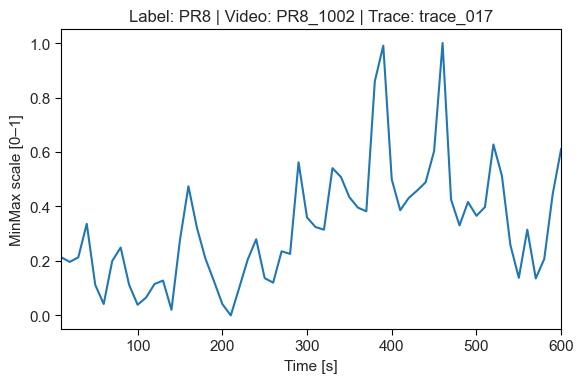

In [6]:
# Extract an example the trace
label = 'PR8'
video = 'PR8_1002'
trace = 'trace_017'

# Select the trace safely
trace_series = data.xs((label, video, trace), level=['label', 'video', 'trace'])
trace_series = trace_series.squeeze()  # convert to Series if only one row

# Determine color by strain
color_map = {'PR8': 'tab:blue', 'X31': 'tab:orange'}
line_color = color_map.get(label, 'black')

# Plot setup
sns.set_theme(style="white", font_scale=1, context='notebook')

fig, ax = plt.subplots(figsize=(6, 4))

# Plot the trace
ax.plot(trace_series.index.astype(float), trace_series.values, color=line_color, linewidth=1.5)
ax.set_title(f'Label: {label} | Video: {video} | Trace: {trace}', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=11)
ax.set_ylabel('MinMax scale [0–1]', fontsize=11)

# Axis limits (tight fit, no white space)
ax.set_xlim(trace_series.index.min(), trace_series.index.max())

# Ticks: only bottom + left
ax.tick_params(
    axis='x', which='both',
    bottom=True, top=False,
    length=4, width=0.8, color='black'
)
ax.tick_params(
    axis='y', which='both',
    left=True, right=False,
    length=4, width=0.8, color='black'
)

# Black frame around plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.8)

# Transparent background
fig.patch.set_alpha(0)
ax.set_facecolor('none')

plt.tight_layout()
plt.show()

In [7]:
# Reset the 'cluster' level frothe index
data = data.reset_index(level='cluster')

# Move 'cluster' to the last column
# First, remove it and re-insert it at the end
cluster_col = data.pop('cluster')
data['cluster'] = cluster_col

In [8]:
data['signal_cluster'] = data['cluster'].apply(lambda x: x in {1, 2, 4, 5, 6, 7})

In [9]:
data

10        20        30        40        50  \
label video    trace                                                         
PR8   PR8_3002 trace_005  0.463806  0.347015  0.061940  0.300373  0.453358   
X31   X31_2001 trace_054  0.000000  0.005551  0.148408  0.165388  0.136000   
      X31_4004 trace_025  0.154372  0.353894  0.225630  0.166230  0.291301   
      X31_5003 trace_083  0.134167  0.045764  0.148119  0.081482  0.180712   
               trace_087  0.304409  0.520387  0.469037  0.574286  0.753058   
...                            ...       ...       ...       ...       ...   
      X31_2001 trace_048  0.000000  0.245024  0.224183  0.353173  0.237139   
               trace_065  0.000000  0.374889  0.043111  0.436667  0.356444   
               trace_076  0.000000  0.193741  0.159856  0.200718  0.366753   
               trace_080  0.408713  0.179914  0.191553  0.175258  0.440971   
               trace_083  0.568278  0.289586  0.486982  0.060840  0.000000   

                                60        70        80        90       100  \
label video    trace                                                         
PR8   PR8_3002 trace_005  0.302985  0.513060  0.204478  0.305597  0.000000   
X31   X31_2001 trace_054  0.074776  0.185796  0.282286  0.202939  0.456816   
      X31_4004 trace_025  0.437806  0.363357  0.346027  0.213773  0.530498   
      X31_5003 trace_083  0.231053  0.018640  0.042639  0.020203  0.000000   
               trace_087  0.671636  0.379715  0.471713  0.541539  0.192023   
...                            ...       ...       ...       ...       ...   
      X31_2001 trace_048  0.238453  0.316748  0.466767  0.458881  0.259294   
               trace_065  0.262222  0.211333  0.251556  0.382667  0.262222   
               trace_076  0.325992  0.350209  0.277457  0.313534  0.332868   
               trace_080  0.263053  0.292983  0.399401  0.120053  0.302295   
               trace_083  0.258236  0.822795  0.477683  0.664187  0.311637   

                          ...       530       540       550       560  \
label video    trace      ...                                           
PR8   PR8_3002 trace_005  ...  0.401493  0.323881  0.220149  0.533582   
X31   X31_2001 trace_054  ...  0.362776  0.231184  0.376327  0.395592   
      X31_4004 trace_025  ...  0.331661  0.168624  0.319804  0.339642   
      X31_5003 trace_083  ...  0.241880  0.255051  0.157384  0.245786   
               trace_087  ...  0.292941  0.363660  0.475280  0.575178   
...                       ...       ...       ...       ...       ...   
      X31_2001 trace_048  ...  0.384529  0.357116  0.546189  0.342846   
               trace_065  ...  0.476889  0.595556  0.268444  0.240667   
               trace_076  ...  0.443592  0.537772  0.517640  0.481662   
               trace_080  ...  0.159295  0.443299  0.149983  0.235451   
               trace_083  ...  0.287726  0.527630  0.653029  0.428002   

                               570       580       590       600  cluster  \
label video    trace                                                        
PR8   PR8_3002 trace_005  0.297761  0.632090  0.302985  0.256343        1   
X31   X31_2001 trace_054  0.372898  0.320816  0.392163  0.635918        1   
      X31_4004 trace_025  0.426747  0.123475  0.167028  0.087105        1   
      X31_5003 trace_083  0.330282  0.276035  0.352718  0.727871        1   
               trace_087  0.627421  0.698267  0.277905  0.167304        1   
...                            ...       ...       ...       ...      ...   
      X31_2001 trace_048  0.473151  0.555389  0.315434  0.431468        9   
               trace_065  0.361111  0.516889  0.467556  0.501556        9   
               trace_076  0.399342  0.516942  0.529400  0.697628        9   
               trace_080  0.554041  0.332557  0.297639  0.189225        9   
               trace_083  0.538789  0.500000  0.736185  0.590329        9   

                          signal_cluster  
label v

In [10]:
# Select only the signal columns (e.g., "0", "10", ..., "600")
signal_columns = [col for col in data.columns if str(col).isdigit()]
# Sum across time points (i.e., across the row)
data["cum_sum"] = data[signal_columns].sum(axis=1)
data["signal_cum_sum"] = data["cum_sum"] < 28.17
data

10        20        30        40        50  \
label video    trace                                                         
PR8   PR8_3002 trace_005  0.463806  0.347015  0.061940  0.300373  0.453358   
X31   X31_2001 trace_054  0.000000  0.005551  0.148408  0.165388  0.136000   
      X31_4004 trace_025  0.154372  0.353894  0.225630  0.166230  0.291301   
      X31_5003 trace_083  0.134167  0.045764  0.148119  0.081482  0.180712   
               trace_087  0.304409  0.520387  0.469037  0.574286  0.753058   
...                            ...       ...       ...       ...       ...   
      X31_2001 trace_048  0.000000  0.245024  0.224183  0.353173  0.237139   
               trace_065  0.000000  0.374889  0.043111  0.436667  0.356444   
               trace_076  0.000000  0.193741  0.159856  0.200718  0.366753   
               trace_080  0.408713  0.179914  0.191553  0.175258  0.440971   
               trace_083  0.568278  0.289586  0.486982  0.060840  0.000000   

                                60        70        80        90       100  \
label video    trace                                                         
PR8   PR8_3002 trace_005  0.302985  0.513060  0.204478  0.305597  0.000000   
X31   X31_2001 trace_054  0.074776  0.185796  0.282286  0.202939  0.456816   
      X31_4004 trace_025  0.437806  0.363357  0.346027  0.213773  0.530498   
      X31_5003 trace_083  0.231053  0.018640  0.042639  0.020203  0.000000   
               trace_087  0.671636  0.379715  0.471713  0.541539  0.192023   
...                            ...       ...       ...       ...       ...   
      X31_2001 trace_048  0.238453  0.316748  0.466767  0.458881  0.259294   
               trace_065  0.262222  0.211333  0.251556  0.382667  0.262222   
               trace_076  0.325992  0.350209  0.277457  0.313534  0.332868   
               trace_080  0.263053  0.292983  0.399401  0.120053  0.302295   
               trace_083  0.258236  0.822795  0.477683  0.664187  0.311637   

                          ...       550       560       570       580  \
label video    trace      ...                                           
PR8   PR8_3002 trace_005  ...  0.220149  0.533582  0.297761  0.632090   
X31   X31_2001 trace_054  ...  0.376327  0.395592  0.372898  0.320816   
      X31_4004 trace_025  ...  0.319804  0.339642  0.426747  0.123475   
      X31_5003 trace_083  ...  0.157384  0.245786  0.330282  0.276035   
               trace_087  ...  0.475280  0.575178  0.627421  0.698267   
...                       ...       ...       ...       ...       ...   
      X31_2001 trace_048  ...  0.546189  0.342846  0.473151  0.555389   
               trace_065  ...  0.268444  0.240667  0.361111  0.516889   
               trace_076  ...  0.517640  0.481662  0.399342  0.516942   
               trace_080  ...  0.149983  0.235451  0.554041  0.332557   
               trace_083  ...  0.653029  0.428002  0.538789  0.500000   

                               590       600  cluster  signal_cluster  \
label video    trace                                                    
PR8   PR8_3002 trace_005  0.302985  0.256343        1            True   
X31   X31_2001 trace_054  0.392163  0.635918        1            True   
      X31_4004 trace_025  0.167028  0.087105        1            True   
      X31_5003 trace_083  0.352718  0.727871        1            True   
               trace_087  0.277905  0.167304        1            True   
...                            ...       ...      ...             ...   
      X31_2001 trace_048  0.315434  0.431468        9           False   
               trace_065  0.467556  0.501556        9           False   
               trace_076  0.529400  0.697628        9           False   
               trace_080  0.297639  0.189225        9           False   
               trace_083  0.736185  0.590329        9           False   

                            cum_sum  signal_cum_sum  
label video    trace                            

In [11]:
def run_peak_feature_extraction(
    data: pd.DataFrame,
    all_cols,
    test_name="testx",
    height=0.0,
    prominence=0.0,
    width=0.0,
    distance=3,
    min_high_peaks=4,
    high_peak_threshold=0.7,
    random_seed=42,
    n_samples_total=10,
    dateiname="Peak_Feature_Extraction"
):
    """Complete pipeline for peak feature extraction, sampling, and visualization."""

    # Session flag handling
    global _peak_session_initialized
    if "_peak_session_initialized" not in globals():
        print("Initializing new peak feature extraction session...")
        _peak_session_initialized = True

        combined_file = os.path.join(dateiname, "combined_signal_output.tsv")
        if os.path.exists(combined_file):
            os.remove(combined_file)
            print("Deleted old combined_signal_output.tsv for a clean start.")

    # Ensure output directory exists
    os.makedirs(dateiname, exist_ok=True)

    print(f"\n=== Running Peak Feature Extraction: {test_name} ===")
    np.random.seed(random_seed)

    # Detect peaks
    all_peaks = []
    peak_counts = {}
    background_flags = {}

    # ensure columns are in numeric/time order
    all_cols = sorted(all_cols)
    for idx, row in data.iterrows():
        # ensure numeric array (protect against object dtype)
        trace = row[all_cols].to_numpy(dtype=float, copy=False)

        # match old call exactly: height=0, prominence=0, width=0, distance=3 (defaulted above)
        peaks, properties = find_peaks(
            trace,
            height=height,
            prominence=prominence,
            width=width,
            distance=distance
        )

        peak_heights = properties.get("peak_heights", np.array([]))
        num_high_peaks = int(np.sum(peak_heights > high_peak_threshold))
        
        # Flexible classification logic
        # Count how many peaks are above the height threshold
        peak_heights = properties.get("peak_heights", np.array([]))
        num_high_peaks = int(np.sum(peak_heights > high_peak_threshold))
        
        # If min_high_peaks > 0, use the strict rule:
        # background if there are at least that many high peaks
        if min_high_peaks > 0:
            is_background = num_high_peaks >= min_high_peaks
        else:
            # Otherwise, background if there are no peaks at all
            is_background = len(peaks) == 0

        all_peaks.append({
            "trace_index": idx,
            "peak_indices": peaks,
            "peak_heights": peak_heights,
            "prominences": properties.get("prominences", None),
            "is_background": is_background,
        })

        peak_counts[idx] = len(peaks)
        background_flags[idx] = is_background

    num_background = int(np.sum(list(background_flags.values())))
    num_traces_with_peaks = sum(len(x["peak_indices"]) > 0 for x in all_peaks)
    print(f"Background traces: {num_background}")
    print(f"Traces with peaks: {num_traces_with_peaks}")

    if num_traces_with_peaks == 0:
        print("No peaks detected — try lowering height/prominence or threshold.")
        return data, None, all_peaks

    # Build peak feature DataFrame
    df = pd.DataFrame.from_dict(peak_counts, orient="index").reset_index(names="ix")
    df["is_background"] = df["ix"].map(background_flags)
    df[["label", "video", "trace"]] = pd.DataFrame(df["ix"].tolist(), index=df.index)
    df = df.drop(columns=["ix"]).set_index(["label", "video", "trace"])

    num_col = f"num_peaks_{test_name}"
    signal_col = f"signal_peaks_{test_name}"
    df = df.rename(columns={0: num_col})
    # signal = NOT background (same as your old step 3)
    df[signal_col] = ~df["is_background"]
    df = df[[num_col, signal_col]]

    # Merge into main dataset
    df = df.reindex(data.index)
    data[num_col] = df[num_col]
    data[signal_col] = df[signal_col]

    # Load previous results (and merge safely)
    combined_file = os.path.join(dateiname, "combined_signal_output.tsv")
    if os.path.exists(combined_file):
        old_data = pd.read_csv(combined_file, sep="\t", index_col=[0, 1, 2])
        old_cols = [c for c in old_data.columns if c not in data.columns]
        if old_cols:
            data = data.join(old_data[old_cols], how="outer")

    # Plot random trace visualization
    labels = data.index.get_level_values("label")
    pr8_idx = [i for i, p in enumerate(all_peaks) if labels[i] == "PR8" and len(p["peak_indices"]) > 0]
    x31_idx = [i for i, p in enumerate(all_peaks) if labels[i] == "X31" and len(p["peak_indices"]) > 0]
    
    n_pr8 = min(len(pr8_idx), n_samples_total // 2)
    n_x31 = min(len(x31_idx), n_samples_total - n_pr8)
    if n_pr8 + n_x31 == 0:
        print("No traces with peaks to visualize.")
        return data, df, all_peaks
    
    sampled_pr8 = np.random.choice(pr8_idx, size=n_pr8, replace=False) if n_pr8 > 0 else []
    sampled_x31 = np.random.choice(x31_idx, size=n_x31, replace=False) if n_x31 > 0 else []
    random_positions = np.concatenate([sampled_pr8, sampled_x31])
    np.random.shuffle(random_positions)
    
    time = [float(t) for t in all_cols]
    color_map = {"PR8": "tab:blue", "X31": "tab:orange"}
    
    fig, axes = plt.subplots(5, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, pos in enumerate(random_positions[:10]):
        row = data.iloc[pos]
        label, video, trace_name = row.name
        trace = row[all_cols].values
        peaks = all_peaks[pos]["peak_indices"]
        color = color_map.get(label, "black")
    
        ax = axes[i]
        ax.plot(time, trace, color=color, linewidth=1.5)
        ax.plot([time[p] for p in peaks], trace[peaks], "ro", markersize=4)
        ax.set_title(f"Label: {label} | Video: {video} | Trace: {trace_name}", fontsize=9)
        ax.tick_params(axis="x", bottom=True, top=False)
        ax.tick_params(axis="y", left=True, right=False)
    
        # Remove whitespace at beginning and end
        ax.set_xlim(time[0], time[-1])
    
        # Clean up subplot borders
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
            spine.set_color("black")
    
    # Add y-axis labels (one per row on the left)
    for i in range(0, len(axes), 2):
        axes[i].set_ylabel("MinMax scale", fontsize=11)
    
    # Add x-axis labels (bottom row only)
    for ax in axes[-2:]:
        ax.set_xlabel("Time [s]", fontsize=11)
    
    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
    plt.savefig(os.path.join(dateiname, f"Subplots.png"), dpi=300, bbox_inches="tight")
    plt.show()

    
    # Partitioning heatmap (include all tests)
    base_methods = ["signal_cluster", "signal_cum_sum"]
    signal_tests = [c for c in data.columns if isinstance(c, str) and c.startswith("signal_peaks_")]
    methods = [m for m in base_methods if m in data.columns] + signal_tests
    
    data_sorted = data.sort_values("cluster").reset_index(drop=True)
    plot_matrix = data_sorted[methods].astype(int).T
    
    fig, ax = plt.subplots(figsize=(15, max(4, len(methods) * 0.3)))
    cax = ax.matshow(plot_matrix, cmap="viridis_r", aspect="auto", vmin=0, vmax=1)
    ax.set_yticks(range(len(methods)))
    ax.set_yticklabels(methods)
    ax.set_xlabel("Sample index (sorted by cluster)")
    ax.set_title("Signal vs. Background Partitioning per Method")
    ax.xaxis.set_ticks_position("bottom")
    fig.colorbar(cax, label="0 = Background | 1 = Signal")
    plt.tight_layout()
    plt.savefig(os.path.join(dateiname, f"Partitioning_heatmap.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    
    # ARI Matrix
    signal_cols = [c for c in data.columns if isinstance(c, str) and c.startswith("signal_")]
    n = len(signal_cols)
    ari_matrix = np.zeros((n, n))
    for i, c1 in enumerate(signal_cols):
        for j, c2 in enumerate(signal_cols):
            ari_matrix[i, j] = adjusted_rand_score(data[c1].astype(int), data[c2].astype(int))
    
    fig, ax = plt.subplots(figsize=(max(8, n * 0.5), max(7, n * 0.5)))
    sns.heatmap(
        ari_matrix,
        xticklabels=signal_cols,
        yticklabels=signal_cols,
        annot=True,
        fmt=".2f",
        cmap="plasma",
        vmin=0, vmax=1,
        linewidths=0.5,
        linecolor="white",
        cbar=True,
        ax=ax,
    )
    
    # Add black outline around the colorbar
    cbar = ax.collections[0].colorbar
    for spine in cbar.ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)
    
    # Add black border around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)
    
    # Add axis ticks
    ax.set_xticks(np.arange(len(signal_cols)) + 0.5)
    ax.set_yticks(np.arange(len(signal_cols)) + 0.5)
    ax.tick_params(axis="x", bottom=True, top=False, labelrotation=90, labelsize=9)
    ax.tick_params(axis="y", left=True, right=False, labelrotation=0, labelsize=9)
    
    ax.set_xlabel("Signal Detection Method", fontsize=12)
    ax.set_ylabel("Signal Detection Method", fontsize=12)
    ax.set_title("Adjusted Rand Index between signal detection methods", fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dateiname, f"ARI_matrix.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    
    # Save updated combined results
    data.to_csv(os.path.join(dateiname, "combined_signal_output.tsv"), sep="\t", index=True)
    return data, df, all_peaks


=== Running Peak Feature Extraction: test1 ===
Background traces: 2156
Traces with peaks: 2825


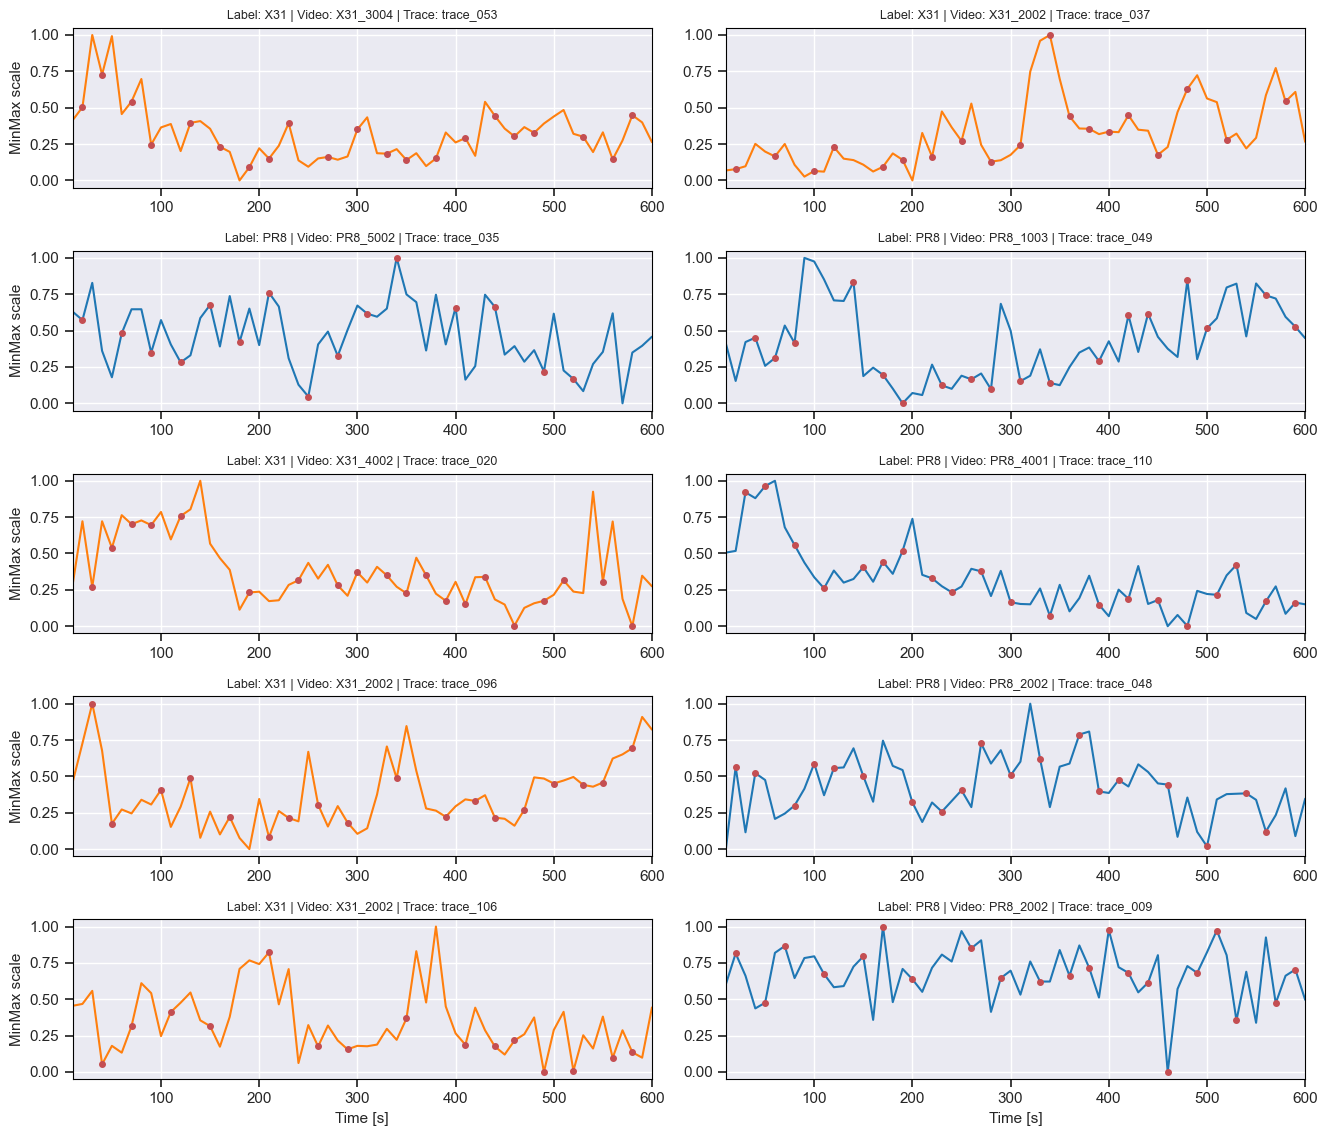

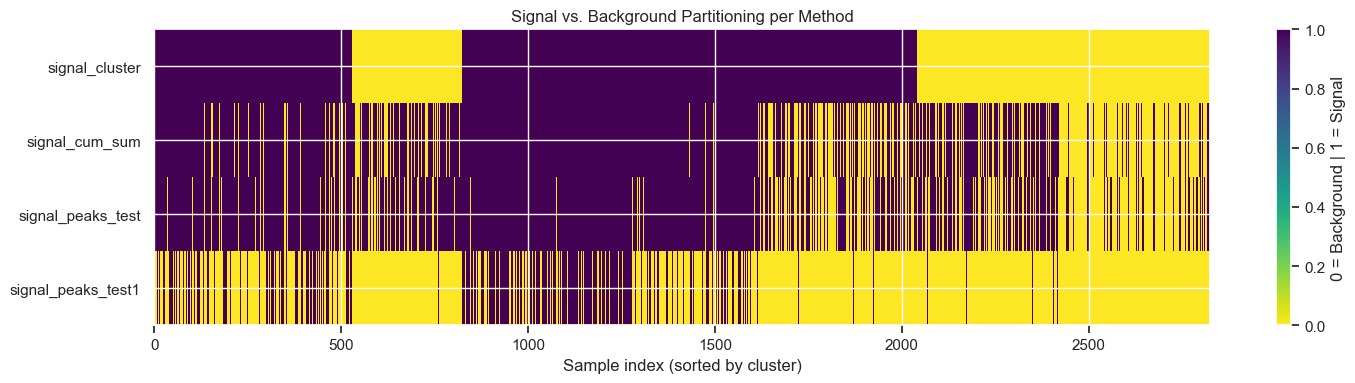

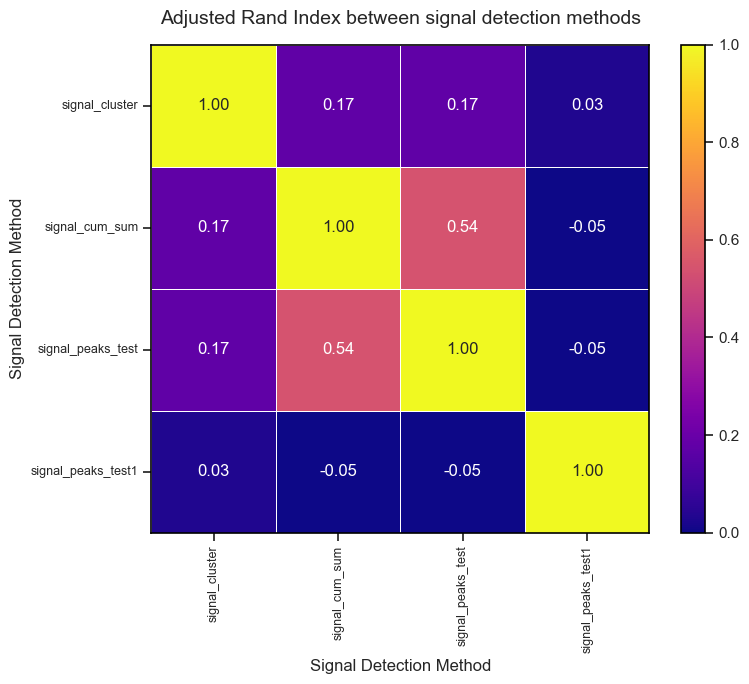

In [13]:
time_cols = [col for col in data.columns if isinstance(col, int)]
time_cols = sorted(time_cols)

# Call the function
data, df, all_peaks = run_peak_feature_extraction(
    data=data,
    all_cols=time_cols,
    test_name="test1",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=7,
    high_peak_threshold=0.5
)

    test_name="test",
    height=0.8,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=0,
    high_peak_threshold=0
    
    test_name="test1",
    height=0,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=0,
    high_peak_threshold=0

    test_name="test2",
    height=0,
    prominence=0.6,
    width=(2,6),
    distance=1,
    min_high_peaks=5,
    high_peak_threshold=0.7,

    test_name="test3",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=5,
    high_peak_threshold=0.7,

    test_name="test4",
    height=0,
    prominence=0,
    width=0,
    distance=1,
    min_high_peaks=7,
    high_peak_threshold=0.7,

    test_name="test5",
    height=0,
    prominence=0,
    width=0,
    distance=3,
    min_high_peaks=5,
    high_peak_threshold=0.6,

    test_name="test6",
    height=0,
    prominence=0,
    width=0,
    distance=2,
    min_high_peaks=8,
    high_peak_threshold=0.7,

    test_name="test7",
    height=0,
    prominence=0,
    width=0,
    distance=2,
    min_high_peaks=7,
    high_peak_threshold=0.65,

    test_name="test8",
    height=0,
    prominence=0.6,
    width=(1,3),
    distance=2,
    min_high_peaks=0,
    high_peak_threshold=0,